**Prueba desempeño**

Parámetros de la prueba:

Arquitectura: Inception V3


Datos:skin-cancer-3- CLASES


Data Augmentation: No


K-Fold Validation: si


Hyperparameter Tuning: No

Parámetros estáticos de entrenamiento:


lr = 1e-3

init = 'normal'

activ = 'relu'

activ_last = 'softmax'

optim = 'adam'

epochs = 40 

batch_size = TENER CUIDADO 


In [1]:
# Librerias Basicas 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
import PIL.Image
from IPython.display import Image
# Librerias de preprocesamiento y metricas
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
# Librerias para backend, arquitectura y entrenamiento
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.layers.core import Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

**LLAMAR LOS DATOS**


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir Incep_BM

Mounted at /content/drive


In [3]:
# identificar las rutas y los nombres de las carpetas
folder_carcinoma_train = '../content/drive/MyDrive/data_todo/Train_val/basal_cell_carcinoma_and_squamous_cell_carcinoma'
folder_melanoma_train = '../content/drive/MyDrive/data_todo/Train_val/melanoma'
folder_keratosis_train= '../content/drive/MyDrive/data_todo/Train_val/pigmented_bening_keratosis'

folder_carcinoma_test = '../content/drive/MyDrive/data_todo/Test/basal_cell_carcinoma_and_squamous_cell_carcinoma'
folder_melanoma_test = '../content/drive/MyDrive/data_todo/Test/melanoma'
folder_keratosis_test = '../content/drive/MyDrive/data_todo/Test/pigmented_bening_keratosis'

train_data_dir = '../content/drive/MyDrive/data_todo/Train_val'
test_data_dir ='../content/drive/MyDrive/data_todo/Test'

**proceso de datos**

In [4]:
read = lambda imname: np.asarray(PIL.Image.open(imname).convert("RGB"))

import cv2

def resize_img(img):
  width , height = 224,224
  resize_image = []
  full_size_image = img
  resize_image.append(cv2.resize(full_size_image, (width , height), interpolation=cv2.INTER_CUBIC))
  return resize_image[0]

# cargar las imagenes de train 
ims_carcinoma = [read(os.path.join(folder_carcinoma_train, filename)) for filename in os.listdir(folder_carcinoma_train)]
X_carcinoma=[]
for img in ims_carcinoma:
  X_carcinoma.append(np.array(resize_img(img), dtype='uint8'))

#print (X_carcinoma)
ims_melanoma = [read(os.path.join(folder_melanoma_train, filename)) for filename in os.listdir(folder_melanoma_train)]
X_melanoma=[]
for img in ims_melanoma:
  X_melanoma.append(np.array(resize_img(img), dtype='uint8'))

ims_keratosis = [read(os.path.join(folder_keratosis_train, filename)) for filename in os.listdir(folder_keratosis_train)]
X_keratosis=[]
for img in ims_keratosis:
  X_keratosis.append(np.array(resize_img(img), dtype='uint8'))


In [ ]:
# Cargar las imagenes de test
ims_carcinoma = [read(os.path.join(folder_carcinoma_test, filename)) for filename in os.listdir(folder_carcinoma_test)]
X_carcinoma_test=[]
for img in ims_carcinoma:
  X_carcinoma_test.append(np.array(resize_img(img), dtype='uint8'))

ims_melanoma = [read(os.path.join(folder_melanoma_test, filename)) for filename in os.listdir(folder_melanoma_test)]
X_melanoma_test=[]
for img in ims_melanoma:
  X_melanoma_test.append(np.array(resize_img(img), dtype='uint8'))

ims_keratosis = [read(os.path.join(folder_keratosis_test, filename)) for filename in os.listdir(folder_keratosis_test)]
X_keratosis_test=[]
for img in ims_keratosis:
  X_keratosis_test.append(np.array(resize_img(img), dtype='uint8'))


In [ ]:
# Crear etiquetas
y_carcinoma = np.zeros(np.shape(X_carcinoma)[0])
y_melanoma = np.ones(np.shape(X_melanoma)[0])
y_keratosis = 2*np.ones(np.shape(X_keratosis)[0])

y_carcinoma_test = np.zeros(np.shape(X_carcinoma_test)[0])
y_melanoma_test = np.ones(np.shape(X_melanoma_test)[0])
y_keratosis_test = 2*np.ones(np.shape(X_keratosis_test)[0])

In [ ]:
print("ENTRENAMIENTO")
print(np.shape(X_carcinoma))
print(np.shape(X_melanoma))
print(np.shape(X_keratosis))

ENTRENAMIENTO
(675, 224, 224, 3)
(1328, 224, 224, 3)
(1000, 224, 224, 3)


In [ ]:
print("TEST")
print(np.shape(X_carcinoma_test))
print(np.shape(X_melanoma_test))
print(np.shape(X_keratosis_test))

TEST
(136, 224, 224, 3)
(239, 224, 224, 3)
(99, 224, 224, 3)


In [ ]:
# Crear datos combinados para train y test 
X_train = np.concatenate((X_carcinoma, X_melanoma, X_keratosis), axis = 0)
y_train = np.concatenate((y_carcinoma, y_melanoma,y_keratosis), axis = 0)

X_test = np.concatenate((X_carcinoma_test, X_melanoma_test,X_keratosis_test), axis = 0)
y_test = np.concatenate((y_carcinoma_test, y_melanoma_test,y_keratosis_test), axis = 0) 

In [ ]:
# Randomizar los datos
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

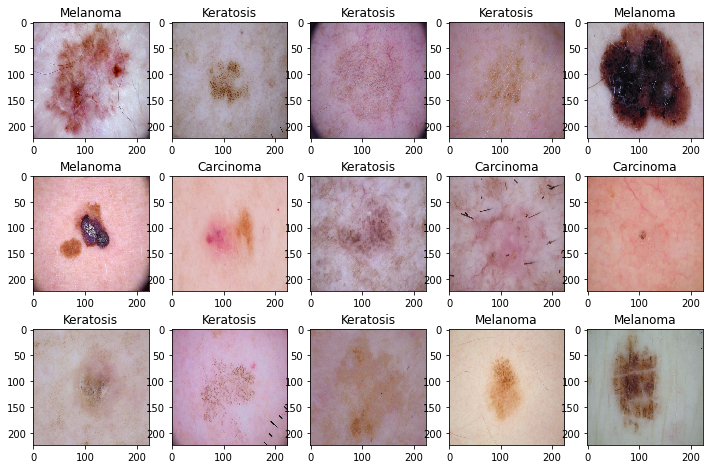

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Carcinoma')
    elif  y_train[i] == 1:
        ax.title.set_text('Melanoma')
    else:
        ax.title.set_text('Keratosis')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

ETIQUETAS CATEGORIAS


In [ ]:
# Etiquetas a categoricas 
y_train = to_categorical(y_train, num_classes= 3)
y_test = to_categorical(y_test, num_classes= 3)

# Normalización 
X_train = X_train/255.
X_test = X_test/255.

In [ ]:
base_model=InceptionV3(input_shape = (224,224,3), weights='imagenet',include_top=False) # importar mobilenet y descartar la ultima capa

x=base_model.output
#x = Flatten()(x)
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) 
#x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x = Dropout(0.2)(x)
preds=Dense(3,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)
Model.summary(model)

87916544/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
from keras import optimizers
input_shape = (224,224,3)
lr = 1e-3
init = 'normal'
activ = 'relu'
optim = keras.optimizers.Adam(learning_rate=lr)
epochs = 100
batch_size = 64
img_height= 224
img_width = 224

train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.1,
        horizontal_flip=True,
        #zoom_range=[0.5,0.5],
        vertical_flip=True,
        validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') 

validation_generator = train_datagen.flow_from_directory(
                                                        train_data_dir, # same directory as training data
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation' # set as validation data
                                                        )


data_train,label_train=train_generator[0]
data_valid,label_valid=validation_generator[0]
#data_test,label_test=test_generador[0]
print("Data_train len:",len(data_train),"label_valid len:",len(label_train))
print("data_valid len:",len(data_valid),"label_valid len:",len(label_valid))
#print("Data_test len:",len(data_test),"label_test len:", len(label_test))




decay_rate = 0;
momentum = 0.8;


# ALMACENADORES PARA CADA FOLD
acc_per_fold = []
loss_per_fold = []
# UNIMOS VALID Y TEST SET

inputs = np.concatenate((data_train, data_valid), axis=0)
targets = np.concatenate((label_train, label_valid), axis=0)

# In[train]
# DEFINIMOS EL K-FLOD CROSS VALIDATOR Y NUMERO DE FOLDS
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-FOLD CROSS VALIDATION
fold_no = 1
for layer in base_model.layers:
        layer.trainable = False

for train, test in kfold.split(inputs, targets):
    if fold_no == 1:
    # GENERAR EL MODELO DE LA RED Y COMPILARLO
    
        input_shape = train.shape
        
    ## INGRESE AQUI SU MODELO ---------------------------------------------------------------------------------
        model=Model(inputs=base_model.input,outputs=preds)
    ## TERMINA EL ESPACIO PARA EL MODELO ----------------------------------------------------------------------
    
    
        
   
    
    rmsprop = optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=decay_rate)
    sgd = optimizers.SGD(lr=lr, momentum=momentum, decay=decay_rate, nesterov=False)
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_rate)

    


    # GENERAR EL REPORTE 
    print('------------------------------------------------------------------------')
    print('ENTRENAMIENTO PARA EL FOLD: ',fold_no)



    # REALIZAR EL ENTRENAMIENTO Y GRAFICAR RESULTADOS
    

    model.compile(optimizer = optim ,loss = "categorical_crossentropy", metrics=["accuracy"])

    
    #checkpoint_filepath = '../content/Incep_BM/best_Model2.h5'

    callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,),
   
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=4,
        verbose=1,  
         min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath='modelo_inceptionv3_3_clases.h5', 
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1, 
        save_best_only=True)
  ]         

    history= model.fit(train_generator, steps_per_epoch=2403/batch_size, epochs=epochs, 
                              validation_data=validation_generator, validation_steps=600/batch_size, verbose=1,
                              callbacks=callbacks_list)

   
    # GENERAR METRICAS DE GENERALIZACIÓN
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print('METRICAS PARA EL FOLD: ',fold_no,': ',model.metrics_names[0],' of ',scores[0],'; ',model.metrics_names[1],' of ',scores[1]*100,'%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

# GENERAR METRICAS GENERALES
    print('------------------------------------------------------------------------')
    print('METRICAS POR FOLD')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print('> Fold ',i+1,' - Loss: ',loss_per_fold[i],' - Accuracy: ',acc_per_fold[i],'%')
    print('------------------------------------------------------------------------')
    print('METRICAS EN PROMEDIO K-FOLD CROSSVALIDATION:')
    print('> Accuracy: ',np.mean(acc_per_fold),' (+- ',np.std(acc_per_fold),')')
    print('> Loss: ',np.mean(loss_per_fold),'}')
    print('------------------------------------------------------------------------')


Found 2403 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Data_train len: 64 label_valid len: 64
data_valid len: 64 label_valid len: 64
------------------------------------------------------------------------
ENTRENAMIENTO PARA EL FOLD:  1
Epoch 1/100
37/37 [==============================] - 43s 899ms/step - loss: 2.3381 - accuracy: 0.4411 - val_loss: 0.8789 - val_accuracy: 0.5917

Epoch 00001: val_accuracy improved from -inf to 0.59167, saving model to modelo_inceptionv3_3_clases.h5
Epoch 2/100
37/37 [==============================] - 31s 826ms/step - loss: 0.8575 - accuracy: 0.6039 - val_loss: 0.8220 - val_accuracy: 0.6183

Epoch 00002: val_accuracy improved from 0.59167 to 0.61833, saving model to modelo_inceptionv3_3_clases.h5
Epoch 3/100
37/37 [==============================] - 31s 822ms/step - loss: 0.7660 - accuracy: 0.6597 - val_loss: 0.8111 - val_accuracy: 0.6200

Epoch 00003: val_accuracy improved from 0.61833 to 0.62000, saving model to modelo_incept

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


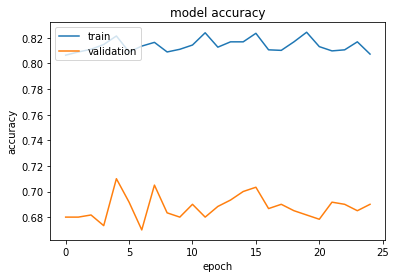

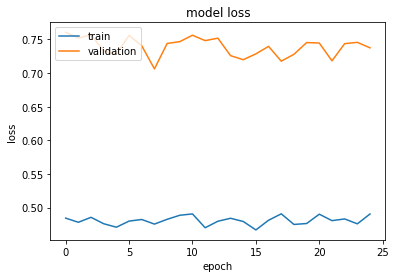

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [5]:
model.save("modelo_inceptionv3_3_clases.h5")
print("Saved model to disk")


NameError: ignored

In [ ]:
#conversion a tlfite
from keras.models import load_model
from tensorflow.keras import layers
import tensorflow_hub as hub
reload = tf.keras.models.load_model('/content/modelo_inceptionv3_3_clases.h5', custom_objects={'KerasLayer': hub.KerasLayer},compile=False)
converter = tf.lite.TFLiteConverter.from_keras_model(reload)
tflite_model = converter.convert()
open("/content/modelo_inceptionv3_3_clases_conv.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpet6gw_5v/assets


95529048

In [ ]:
batch_size = 100
IMG_SHAPE= 224

In [ ]:
#TEST
base_dir_test='/content/drive/MyDrive/data_todo/Test'

TEST_DATASET=os.path.join(base_dir_test)

In [ ]:
#Normalización de 0 a 1 y redimensionamiento 
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=base_dir_test,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='sparse')

Found 474 images belonging to 3 classes.


In [ ]:
#save to matrix of the images of test and save labes as np.array
test_train,label_test=test_data_gen[0]

In [ ]:
#Evaluar el modelo
score= model.evaluate(test_train,label_test,batch_size=batch_size,verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

ValueError: ignored

In [ ]:
#Extraer las etiquetas de las predichas
y_pred_t= np.argmax(model.predict(test_train), axis=-1)

Text(0.5, 0, 'Predicted Label')

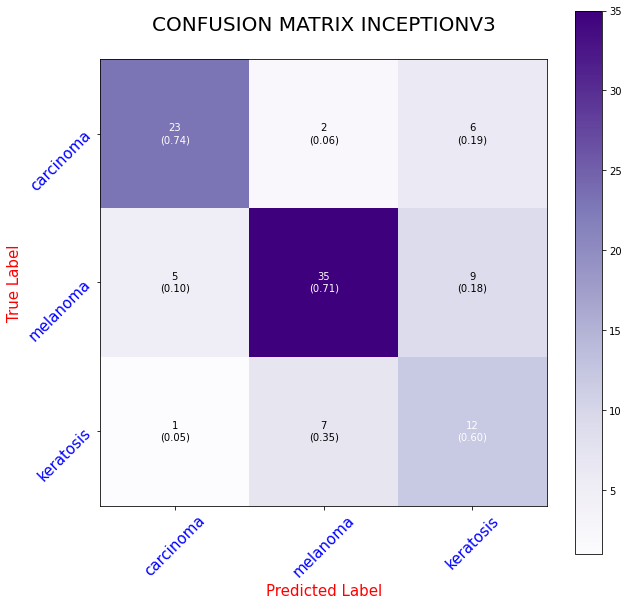

In [ ]:
#Generar la matriz de confusión
from sklearn.metrics     import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
classes = ['carcinoma', 'melanoma', 'keratosis']

mat= confusion_matrix(label_test, y_pred_t)
class_names = ['basal_cell_carcinoma_and_squamous_cell_carcinoma', 'melanoma', 'pigmented_bening_keratosis']
fig, ax= plot_confusion_matrix(conf_mat= mat, figsize=(10,10), show_normed=True, colorbar=True,  cmap= plt.cm.Purples)
sns.set(font_scale=3.0) #edited as suggested
#sns.heatmap(fig,fmt="g");  # annot=True to annotate cells
plt.title('CONFUSION MATRIX INCEPTIONV3', size=20)
tick_marcks= np.arange(len(classes))
plt.xticks(tick_marcks, classes, rotation=45, size=15, color= 'blue')
plt.yticks(tick_marcks, classes, rotation=45, size=15, color= 'blue')
plt.ylabel('True Label', size=15, color= 'red')
plt.xlabel('Predicted Label', size=15, color= 'red')

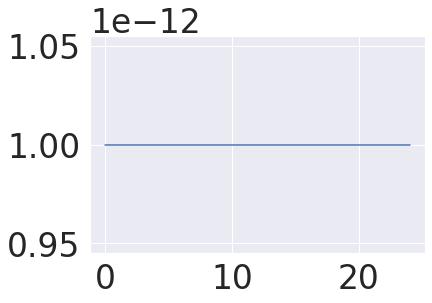

In [ ]:
plt.plot(history.history['lr'])

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
print(classification_report(label_test,y_pred_t))

              precision    recall  f1-score   support

         0.0       0.79      0.74      0.77        31
         1.0       0.80      0.71      0.75        49
         2.0       0.44      0.60      0.51        20

    accuracy                           0.70       100
   macro avg       0.68      0.69      0.68       100
weighted avg       0.72      0.70      0.71       100



In [ ]:
test_datagen = ImageDataGenerator(rescale=1./ 255)
test_generator = test_datagen.flow_from_directory(
                                                    test_data_dir,  
                                                    target_size=(img_height,img_width), 
                                                    batch_size=batch_size,  
                                                    class_mode='categorical',
                                                    shuffle=False
                                                  )


model.load_weights("modelo_inceptionv3_3_clases.h5")
model.evaluate(test_generator, batch_size=128)

import sklearn
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
y_pred = np.fix(y_pred+0.5)
print('F1 score = ',f1_score(y_test, y_pred, average='weighted'))

def get_confusion_matrix(y_true, y_pred, normalized):
    y_pred = np.where(y_pred)
    label_test = y_pred[1]
    y_test = np.where(y_true)
    index = y_test[1]
    n_classes = len(np.unique(y_true))
    M = np.zeros((n_classes, n_classes))
    cont = 0
    for n in range(0,len(index)):
        M[label_test[n]][index[n]] = M[label_test[n]][index[n]]+1
        cont = cont+1
    M.astype('int')
    if normalized == True:
        conf = np.transpose( np.transpose(M)/np.sum(M,axis=1) )
    return conf

conf = get_confusion_matrix(y_test, y_pred, True)
print('Confusion matrix = ')
print(conf)

P = conf.sum(axis=0)
R =  conf.sum(axis=1)
D = R+P
F1i = 2*np.diag(conf)/D
print('F1i Score = ')
print(F1i)

Found 474 images belonging to 3 classes.
5/5 [==============================] - 5s 742ms/step - loss: 0.7599 - accuracy: 0.6709
F1 score =  0.6617181876547706


IndexError: ignored